In [399]:
import json
import pandas as pd
from functools import reduce

In [856]:

import sys, importlib
importlib.reload(sys.modules['edgar_fin_data_services'])
import edgar_fin_data_services as ds

# Functions

In [449]:
def find_in_dict_entry(data:dict,key:str,query:str)->list:
    '''
    Usage e.g. find_in_dict_entry(key='description',query='loan')
    -> Find position for which the word loans occurs in the description
    '''
    li_positions=[]

    for position in data['facts']['us-gaap'].keys():
        if data['facts']['us-gaap'][position][key]:
            if data['facts']['us-gaap'][position][key].lower().find(query)!=-1:
                li_positions.append(position)
    
    return li_positions


In [450]:
def output_entry(data:str,position:str,key:str):
    '''
    Output the JSON entry
    Usage e.g. output_entry('FeesAndCommissionsCreditCards','description')
    '''
    return data['facts']['us-gaap'][position][key]


In [402]:
def transform_to_df(data:dict,key:str)->pd.DataFrame:
    return pd.DataFrame(data['facts']["us-gaap"][key]["units"]["USD"])

In [403]:
def extract_yearly_data(data:dict,position:str)->pd.DataFrame:
    df=transform_to_df(data,position)
    df=df[df.fp=="FY"]
    df['end']=pd.to_datetime(df['end'], format='%Y-%m-%d')
    df['year'] = pd.DatetimeIndex(df['end']).year

    return df.sort_values(['year','fy'],ascending=False).groupby('year').head(1)[["year","val"]].reset_index(drop=True)

In [404]:
def compute_row_change(df:pd.DataFrame)->pd.DataFrame:
    df['change_in_perc']=((df['val']-df['val'].shift(-1))/df['val'])*100
    return df

In [405]:
def merge_li_dfs(key:str,li_df:list)->pd.DataFrame:
    return reduce(lambda  left,right: pd.merge(left,right,on=[key],how='outer'),li_df)

In [480]:
def extract_description(data:dict,tag:str)->str:
    return data['facts']['us-gaap'][tag]["description"]
    

# Companies to be analyzed

## Interest bearing deposit

### Discover Financial

In [691]:
li_company=['discover','synchrony','amex']

dict_fin=dict.fromkeys(li_company)

In [693]:
cik="0001393612"
file_nm="CIK"+cik
f=open('/Users/ezratampubolon/PythonProjects/Financial/edgar-data'+'/companyfacts/'+file_nm+'.json')
dict_fin["discover"]=dict.fromkeys(['data','ib_deposits'])
dict_fin["discover"]["data"]=json.load(f)
f.close

<function TextIOWrapper.close()>

In [857]:
# Define service
DiscoverService=ds.FinancialAnalyze(comp_nm="discover",data=dict_fin["discover"]["data"])

In [858]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="InterestBearingDepositLiabilities",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )

# The data from 2011 to 2013 are missing as they are in another tag:
DiscoverService.add_yearly_data_norm(
    tag="InterestBearingDepositLiabilitiesDomestic",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )

# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
DiscoverService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
DiscoverService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


DiscoverService.dict_df["ib_deposits"]=DiscoverService.dict_df["ib_deposits"].dropna()
DiscoverService.dict_df["ib_deposits"]



,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,70818.000,-6.886667,661.000,0.933379
1,2020,75695.000,4.940881,1231.000,1.626263
2,2019,71955.000,6.769509,1587.000,2.205545
3,2018,67084.000,13.295272,1238.000,1.845447
4,2017,58165.000,11.525832,846.000,1.454483
5,2016,51461.000,8.486038,687.000,1.334992
6,2015,47094.000,2.764683,623.000,1.322886
7,2014,45792.000,2.240566,614.000,1.340846
8,2013,44766.000,6.006791,698.000,1.559219
9,2012,42077.000,6.210043,845.000,2.008223


### Synchrony Financial

In [744]:
cik="0001601712"
file_nm="CIK"+cik
f=open('/Users/ezratampubolon/PythonProjects/Financial/edgar-data'+'/companyfacts/'+file_nm+'.json')
dict_fin["synchrony"]=dict.fromkeys(['data','ib_deposits'])
dict_fin["synchrony"]["data"]=json.load(f)
f.close

<function TextIOWrapper.close()>

In [763]:
# Define service
SynchronyService=ds.FinancialAnalyze(comp_nm="synchrony",data=dict_fin["synchrony"]["data"])

In [764]:
# Initialize data
SynchronyService.init_yearly_data_norm(
    tag="InterestBearingDepositLiabilities",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Compute yearly change
SynchronyService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
SynchronyService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
SynchronyService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


SynchronyService.dict_df["ib_deposits"]=SynchronyService.dict_df["ib_deposits"].dropna()
SynchronyService.dict_df["ib_deposits"]




,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,61911.0,-0.901294,566.0,0.914216
1,2020,62469.0,-3.854712,1094.0,1.751269
2,2019,64877.0,1.755630,1566.0,2.413798
3,2018,63738.0,11.707302,1186.0,1.860742
4,2017,56276.0,7.783069,848.0,1.506859
5,2016,51896.0,16.727686,727.0,1.400879
6,2015,43215.0,19.363647,607.0,1.404605
7,2014,34847.0,27.224725,470.0,1.348753


### American Express

In [747]:
cik="0000004962"
file_nm="CIK"+cik
f=open('/Users/ezratampubolon/PythonProjects/Financial/edgar-data'+'/companyfacts/'+file_nm+'.json')
dict_fin["amex"]=dict.fromkeys(['data','ib_deposits'])
dict_fin["amex"]["data"]=json.load(f)
f.close

<function TextIOWrapper.close()>

In [768]:
# Define service
AmexService=ds.FinancialAnalyze(comp_nm="amex",data=dict_fin["amex"]["data"])

In [769]:
# Initialize data
AmexService.init_yearly_data_norm(
    tag="Deposits",
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Compute yearly change
AmexService.compute_row_change(
    col_nm="interest_bearing_deposit_liabilities",
    df_nm="ib_deposits"
    )


# Add interest expense deposit 
AmexService.add_yearly_data_norm(
    tag="InterestExpenseDeposits",
    col_nm="interest_expense_deposits",
    df_nm="ib_deposits",
    add_row=False
    )

# Compute interest rate deposit 
AmexService.compute_ratio(
    numer_col_nm="interest_expense_deposits",
    denom_col_nm="interest_bearing_deposit_liabilities",
    res_col_nm="interest_rate_deposits",
    df_nm="ib_deposits"
    )


AmexService.dict_df["ib_deposits"]=AmexService.dict_df["ib_deposits"].dropna()
AmexService.dict_df["ib_deposits"]


,year,interest_bearing_deposit_liabilities,interest_bearing_deposit_liabilities_change_in_perc,interest_expense_deposits,interest_rate_deposits
0,2021,84382.0,-2.954422,458.0,0.542770
1,2020,86875.0,15.640863,943.0,1.085468
2,2019,73287.0,4.539686,1559.0,2.127253
3,2018,69960.0,7.873070,1287.0,1.839623
4,2017,64452.0,17.703097,779.0,1.208651
5,2016,53042.0,-3.685758,598.0,1.127408
6,2015,54997.0,19.684710,475.0,0.863683
7,2014,44171.0,5.451541,373.0,0.844445
8,2013,41763.0,4.693149,442.0,1.058353
9,2012,39803.0,4.786071,480.0,1.205939


#### Comparison: Change of Deposits

In [827]:
InterCompanies=ds.InterCompaniesAnalyze(
    [DiscoverService,
    SynchronyService,
    AmexService]
    )

In [828]:
InterCompanies.merge_by_quant(
    df_name="ib_deposits", 
    quantity= "interest_bearing_deposit_liabilities_change_in_perc"
    )

InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]=InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"].dropna()
InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]

,year,discover,synchrony,amex
0,2021,-6.886667,-0.901294,-2.954422
1,2020,4.940881,-3.854712,15.640863
2,2019,6.769509,1.755630,4.539686
3,2018,13.295272,11.707302,7.873070
4,2017,11.525832,7.783069,17.703097
5,2016,8.486038,16.727686,-3.685758
6,2015,2.764683,19.363647,19.684710
7,2014,2.240566,27.224725,5.451541


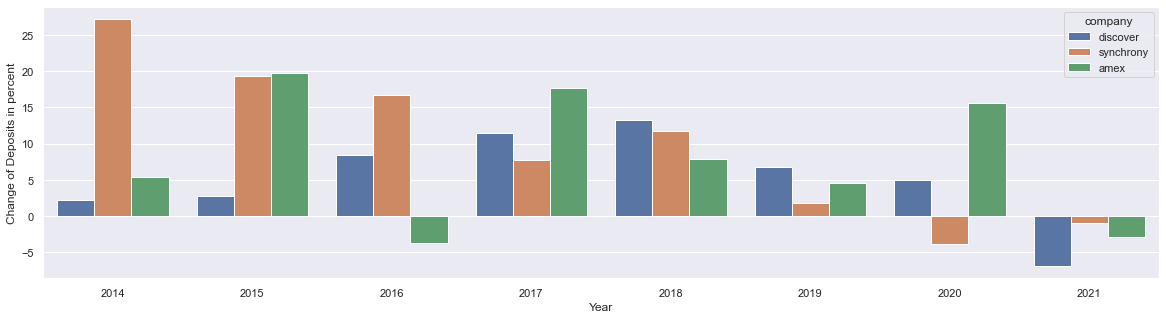

In [774]:
InterCompanies.plot_df(key="interest_bearing_deposit_liabilities_change_in_perc", xlabel="Year", ylabel= "Change of Deposits in percent",width=20,height=5)

### Interest Rate Deposits

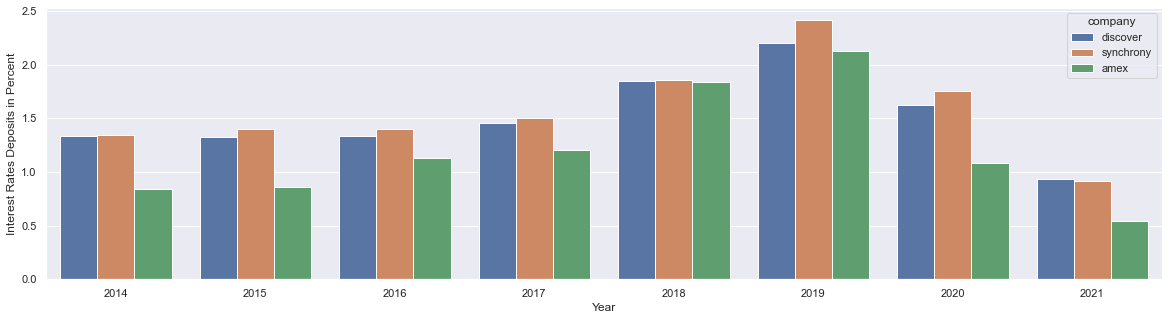

In [775]:
InterCompanies.merge_by_quant(
    df_name="ib_deposits", 
    quantity= "interest_rate_deposits"
    )

InterCompanies.dict_df["interest_rate_deposits"]=InterCompanies.dict_df["interest_rate_deposits"].dropna()
InterCompanies.dict_df["interest_rate_deposits"]


InterCompanies.plot_df(key="interest_rate_deposits", xlabel="Year", ylabel= "Interest Rates Deposits in Percent",width=20,height=5)



## Loans

## Discover

In [859]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="NotesReceivableGross",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# The data is only from 2019 to 2021. So we extract other data
# from other tag:
DiscoverService.add_yearly_data_norm(
    tag="LoansAndLeasesReceivableGrossCarryingAmount",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# The data now is only from 2010. So we extract other data
# from other tag:
DiscoverService.add_yearly_data_norm(
    tag="LoansAndLeasesReceivableConsumer",
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )

# We have multiple data in year 2010. So choose one of them:
DiscoverService.dict_df["loan_receivables"]=DiscoverService.dict_df["loan_receivables"].drop(11).reset_index(drop=True)


# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Add interest loans - Sum of two tags
li_tags=["InterestAndFeeIncomeLoansConsumerInstallmentCreditCard","InterestAndFeeIncomeLoansOtherConsumer"]
[DiscoverService.add_yearly_data_norm(tag=tag,col_nm=tag,df_nm="loan_receivables",add_row=False)for tag in li_tags]
DiscoverService.add_cols(li_col_nm=li_tags,res_col_nm="interest_loans",df_nm="loan_receivables")

# Compute yearly change
DiscoverService.compute_row_change(
    col_nm="interest_loans",
    df_nm="loan_receivables"
    )


# Compute interest rate loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="interest_loans",
    denom_col_nm="loan_receivables",
    res_col_nm="interest_rate_loan_receivables",
    df_nm="loan_receivables"
    )


DiscoverService.dict_df["loan_receivables"]=DiscoverService.dict_df["loan_receivables"].dropna()
DiscoverService.dict_df["loan_receivables"]

,year,loan_receivables,loan_receivables_change_in_perc,interest_loans,interest_loans_change_in_perc,interest_rate_loan_receivables
0,2021,93684.000,3.453098,10451.000,-3.358530,11.155587
1,2020,90449.000,-6.019967,10802.000,-7.026477,11.942642
2,2019,95894.000,5.612447,11561.000,8.649771,12.056020
3,2018,90512.000,6.920629,10561.000,10.358868,11.668066
4,2017,84248.000,8.301681,9467.000,10.045421,11.237062
5,2016,77254.000,6.302586,8516.000,7.597464,11.023377
6,2015,72385.000,3.337708,7869.000,4.562206,10.871037
7,2014,69969.000,5.999800,7510.000,7.123835,10.733325
8,2013,65771.000,5.364066,6975.000,5.275986,10.604978
9,2012,62243.000,8.494128,6607.000,5.055244,10.614848


### Synchrony Financial

In [793]:
# Initialize data
SynchronyService.init_yearly_data_norm(
    tag='LoansAndLeasesReceivableNetOfDeferredIncome',
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Compute yearly change
SynchronyService.compute_row_change(
    col_nm="loan_receivables",
    df_nm="loan_receivables"
    )


# Add corresponding interest income
SynchronyService.add_yearly_data_norm(
    tag="InterestAndFeeIncomeLoansAndLeases",
    col_nm="interest_loans",
    df_nm="loan_receivables",
    add_row=False)




# Compute interest rate loan receivables
SynchronyService.compute_ratio(
    numer_col_nm="interest_loans",
    denom_col_nm="loan_receivables",
    res_col_nm="interest_rate_loan_receivables",
    df_nm="loan_receivables"
    )


SynchronyService.dict_df["loan_receivables"]=SynchronyService.dict_df["loan_receivables"].dropna()
SynchronyService.dict_df["loan_receivables"]

,year,loan_receivables,loan_receivables_change_in_perc,interest_loans,interest_rate_loan_receivables
0,2021,80740.0,-1.395838,15228.0,18.860540
1,2020,81867.0,-6.532547,15950.0,19.482820
2,2019,87215.0,-6.792410,18705.0,21.446999
3,2018,93139.0,12.016449,17644.0,18.943729
4,2017,81947.0,6.845888,16219.0,19.792061
5,2016,76337.0,10.541415,14682.0,19.233137
6,2015,68290.0,10.256260,13179.0,19.298580
7,2014,61286.0,6.578990,12216.0,19.932774


### American Express

ToDo: Data not yet complete

### Comparison

In [829]:
InterCompanies.merge_by_quant(
    df_name="loan_receivables", 
    quantity= "interest_rate_loan_receivables"
    )

#InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"]=InterCompanies.dict_df["interest_bearing_deposit_liabilities_change_in_perc"].dropna()
InterCompanies.dict_df["interest_rate_loan_receivables"]=InterCompanies.dict_df["interest_rate_loan_receivables"].dropna()
InterCompanies.dict_df["interest_rate_loan_receivables"]

,year,discover,synchrony
0,2021,11.155587,18.860540
1,2020,11.942642,19.482820
2,2019,12.056020,21.446999
3,2018,11.668066,18.943729
4,2017,11.237062,19.792061
5,2016,11.023377,19.233137
6,2015,10.871037,19.298580
7,2014,10.733325,19.932774


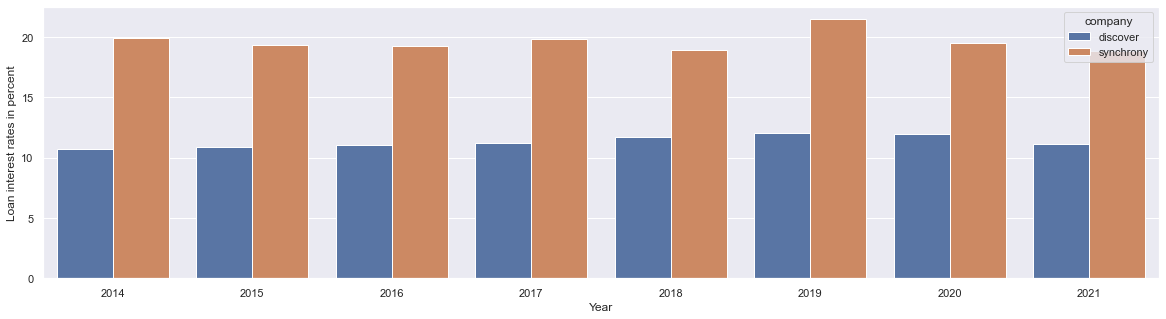

In [830]:
InterCompanies.plot_df(key="interest_rate_loan_receivables", xlabel="Year", ylabel='Loan interest rates in percent',width=20,height=5)

## Credit Risk

### Discover

In [861]:
# Initialize data
DiscoverService.init_yearly_data_norm(
    tag="ProvisionForLoanLossesExpensed",
    col_nm="provision_for_loan_losses",
    df_nm="loan_losses"
    )


DiscoverService.add_yearly_data_norm(
    tag="FinancingReceivableAllowanceForCreditLossesWriteOffs",
    col_nm="write_offs",df_nm="loan_losses",add_row=False)

DiscoverService.add_yearly_data_norm(
    tag="FinancingReceivableAllowanceForCreditLossesRecovery",
    col_nm="recovery",df_nm="loan_losses",add_row=False)

DiscoverService.dict_df["loan_losses"]["net_write_offs"]=DiscoverService.dict_df["loan_losses"]["write_offs"]-DiscoverService.dict_df["loan_losses"]["recovery"]
DiscoverService.dict_df["loan_losses"]["rem_provision"]=DiscoverService.dict_df["loan_losses"]["provision_for_loan_losses"]-DiscoverService.dict_df["loan_losses"]["net_write_offs"]


DiscoverService.add_data_from_other_col(source_df="loan_receivables",source_col="loan_receivables",target_df="loan_losses")

# Compute the ratio between write offs to loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="write_offs",
    denom_col_nm="loan_receivables",
    res_col_nm="write_offs_to_loan_receivables_perc",
    df_nm="loan_losses"
    )

# Compute the ratio between write offs to loan receivables
DiscoverService.compute_ratio(
    numer_col_nm="provision_for_loan_losses",
    denom_col_nm="loan_receivables",
    res_col_nm="provision_to_loan_receivables",
    df_nm="loan_losses"
    )

DiscoverService.dict_df["loan_losses"]

,year,provision_for_loan_losses,write_offs,recovery,net_write_offs,rem_provision,loan_receivables,write_offs_to_loan_receivables_perc,provision_to_loan_receivables
0,2021,227.000,2534.000,903.0,1631.0,-1404.0,93684.000,2.704838,0.242304
1,2020,5117.000,3476.000,741.0,2735.0,2382.0,90449.000,3.843050,5.657332
2,2019,3231.000,3617.000,731.0,2886.0,345.0,95894.000,3.771873,3.369345
3,2018,3035.000,3182.000,570.0,2612.0,423.0,90512.000,3.515556,3.353147
4,2017,586.000,2618.000,499.0,2119.0,-1533.0,84248.000,3.107492,0.695565
5,2016,1859.000,2034.000,473.0,1561.0,298.0,77254.000,2.632873,2.406348
6,2015,1512.000,1855.000,466.0,1389.0,123.0,72385.000,2.562686,2.088831
7,2014,1443.000,1806.000,461.0,1345.0,98.0,69969.000,2.581143,2.062342
8,2013,1086.000,1739.000,513.0,1226.0,-140.0,65771.000,2.644022,1.651184
9,2012,848.000,1909.000,581.0,1328.0,-480.0,62243.000,3.067012,1.362402


In [864]:
print(f"Average yearly net Credit Loss: {sum(DiscoverService.dict_df.get("loan_losses").rem_provision)/12}")

SyntaxError: f-string: unmatched '(' (959294013.py, line 1)

In [523]:
sum(df["write_offs_to_loan_receivables_perc"])/12

3.655277189883467

In [524]:
df["write_offs_to_loan_receivables_perc"].median()

3.0872518587429516

In [525]:
data=dict_fin["synchrony"]["data"]

df=extract_yearly_data(data,'ProvisionForLoanLossesExpensed')
df['val']=df['val']/1000000
df=df.rename(columns={"val":"provision_for_loan_losses"})

df_temp=extract_yearly_data(data,"AllowanceForLoanAndLeaseLossesWriteOffs")
df_temp['val']=df_temp['val']/1000000
df_temp=df_temp.rename(columns={"val":"write_offs"})
df=pd.merge(df,df_temp,on=['year'],how='outer').dropna()

df_temp=extract_yearly_data(data,"AllowanceForLoanAndLeaseLossRecoveryOfBadDebts")
df_temp['val']=df_temp['val']/1000000
df_temp=df_temp.rename(columns={"val":"recovery"})
df=pd.merge(df,df_temp,on=['year'],how='outer').dropna()

df["net_write_offs"]=df["write_offs"]-df["recovery"]
df["rem_provision"]=df["provision_for_loan_losses"]-df["net_write_offs"]

df_temp=dict_fin["synchrony"]["loan_receivables"][["year","loan_receivables"]]
df=pd.merge(df,df_temp,on=['year'],how='outer').dropna()
df["write_offs_to_loan_receivables_perc"]=(df["write_offs"]/df["loan_receivables"])*100
df

df

,year,provision_for_loan_losses,write_offs,recovery,net_write_offs,rem_provision,loan_receivables,write_offs_to_loan_receivables_perc
0,2021,726.0,3148.0,844.0,2304.0,-1578.0,80740.0,3.898935
1,2020,5310.0,4606.0,938.0,3668.0,1642.0,81867.0,5.626199
2,2019,4180.0,6032.0,1027.0,5005.0,-825.0,87215.0,6.916241
3,2018,5545.0,5544.0,852.0,4692.0,853.0,93139.0,5.952394
4,2017,5296.0,4998.0,932.0,4066.0,1230.0,81947.0,6.099064
5,2016,3986.0,3969.0,830.0,3139.0,847.0,76337.0,5.199314
6,2015,2952.0,3371.0,680.0,2691.0,261.0,68290.0,4.936301
7,2014,2917.0,3189.0,616.0,2573.0,344.0,61286.0,5.203472


In [526]:
sum(df["rem_provision"])/12

231.16666666666666

In [481]:
extract_description(data,"ProvisionForLoanLossesExpensed")

'Amount of credit loss expense (reversal of expense) for financing receivable.'

In [488]:
df=extract_yearly_data(data,"FinancingReceivableAllowanceForCreditLossesWriteOffs")
df['val']=df['val']/1000000
df

,year,val
0,2021,2534.000
1,2020,3476.000
2,2019,3617.000
3,2018,3182.000
4,2017,2618.000
5,2016,2034.000
6,2015,1855.000
7,2014,1806.000
8,2013,1739.000
9,2012,1909.000


In [482]:
data=dict_fin["synchrony"]["data"]
df=extract_yearly_data(data,"ProvisionForLoanLossesExpensed")

In [484]:
df['val']=df['val']/1000000

In [485]:
df

,year,val
0,2021,726.0
1,2020,5310.0
2,2019,4180.0
3,2018,5545.0
4,2017,5296.0
5,2016,3986.0
6,2015,2952.0
7,2014,2917.0
8,2013,3072.0
9,2012,2565.0


# Cash Flow Analysis

In [545]:
data=dict_fin["discover"]["data"]

In [547]:
df=extract_yearly_data(data,"NetCashProvidedByUsedInOperatingActivities")
df.val=df.val/1000000
df=df.rename(columns={"val":"op_cash_flow"})

df

,year,op_cash_flow
0,2021,6019.000
1,2020,6196.000
2,2019,6196.000
3,2018,5191.000
4,2017,5208.000
5,2016,4425.000
6,2011,3609.615
7,2010,3872.586
8,2009,3597.892
9,2008,4504.159
